### Using the WOA2018 version. With NO3, SiO3 and PO4 regridded to a 180 by 360 grid. 

In [1]:
import warnings
warnings.simplefilter("ignore") # Silence warnings
from mpl_toolkits.basemap import Basemap
import matplotlib.pyplot as plt
import numpy as np
#import hvplot.xarray
import xarray as xr
import numpy as np
from matplotlib.pyplot import figure
import numpy.ma as ma
from netCDF4 import Dataset as NetCDFFile
import glob
import cartopy
import cartopy.crs as ccrs
import pylab 
from copy import deepcopy
import pandas as pd
import matplotlib
import matplotlib.colors as colors
from cartopy.util import add_cyclic_point
import matplotlib.gridspec as gridspec
plt.rcParams['mathtext.default']='regular'
from collections import OrderedDict
import cmocean

In [2]:
class MidpointNormalize(colors.Normalize):
    def __init__(self, vmin=None, vmax=None, midpoint=None, clip=False):
        self.midpoint = midpoint
        colors.Normalize.__init__(self, vmin, vmax, clip)

    def __call__(self, value, clip=None):
        if clip is None:
            clip = self.clip

        result, is_scalar = self.process_value(value)

        self.autoscale_None(result)
        vmin, vmax, midpoint = self.vmin, self.vmax, self.midpoint

        if not (vmin < midpoint < vmax):
            raise ValueError("midpoint must be between maxvalue and minvalue.")
        elif vmin == vmax:
            result.fill(0) # Or should it be all masked? Or 0.5?
        elif vmin > vmax:
            raise ValueError("maxvalue must be bigger than minvalue")
        else:
            vmin = float(vmin)
            vmax = float(vmax)
            if clip:
                mask = np.ma.getmask(result)
                result = np.ma.array(np.clip(result.filled(vmax), vmin, vmax),
                                  mask=mask)

            # ma division is very slow; we can take a shortcut
            resdat = result.data

            #First scale to -1 to 1 range, than to from 0 to 1.
            resdat -= midpoint
            resdat[resdat>0] /= abs(vmax - midpoint)
            resdat[resdat<0] /= abs(vmin - midpoint)

            resdat /= 2.
            resdat += 0.5
            result = np.ma.array(resdat, mask=result.mask, copy=False)

        if is_scalar:
            result = result[0]
        return result

## Input file

In [3]:
print('What is the new file? (new_file)')
new_file = input('')
print('What year? (year)')
year = input('')

What is the new file? (new_file)


 GNG595


What year? (year)


 20yrclim


In [4]:
import re
numbers = re.compile(r'(\d+)')
def numericalSort(value):
    parts = numbers.split(value)
    parts[1::2] = map(int, parts[1::2])
    return parts

In [5]:
### 20 year climatology GNG513b from 43 to 62 representing Jan 1990 - Dec 2009. 
newNCDFfiles = sorted(glob.glob('/glade/scratch/gabyn/GNG595_2ndcycle_20year_clim/*', recursive=True),
                      key=numericalSort)

In [6]:
ds = xr.open_mfdataset(newNCDFfiles,combine='by_coords')

## Import regridded SPECTRA NO3, PO4, SiO3

In [7]:
no3_inds = sorted(glob.glob('/glade/scratch/gabyn/GNG595_2ndcycle_20year_clim_remap/regrid_GNG595_NO3.*.nc', recursive=True))
no3_ds = xr.open_mfdataset(no3_inds,combine='by_coords')
po4_inds = sorted(glob.glob('/glade/scratch/gabyn/GNG595_2ndcycle_20year_clim_remap/regrid_GNG595_PO4.*.nc', recursive=True))
po4_ds = xr.open_mfdataset(po4_inds,combine='by_coords')
sio3_inds = sorted(glob.glob('/glade/scratch/gabyn/GNG595_2ndcycle_20year_clim_remap/regrid_GNG595_SiO3.*.nc', recursive=True))
sio3_ds = xr.open_mfdataset(sio3_inds,combine='by_coords')

## Observational datasets

In [8]:
obsfile_po4='/glade/u/home/gabyn/obs/woa18_all_p00_01.nc.nc4'
po4 = xr.open_mfdataset(obsfile_po4,decode_times=False)
obsfile_no3='/glade/u/home/gabyn/obs/woa18_all_n00_01.nc.nc4'
no3 = xr.open_mfdataset(obsfile_no3,decode_times=False)
obsfile_sio3='/glade/u/home/gabyn/obs/woa18_all_i00_01.nc.nc4'
sio3 = xr.open_mfdataset(obsfile_sio3,decode_times=False)

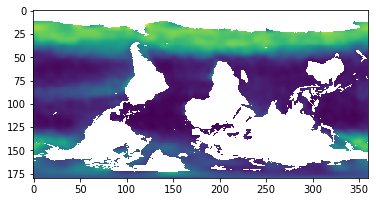

In [9]:
plt.imshow(po4.p_an[0,0,:,:])

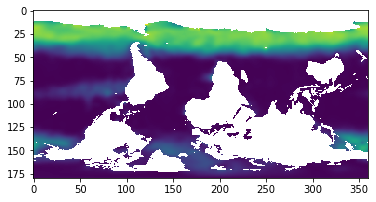

In [10]:
plt.imshow(no3.n_an[0,0,:,:])

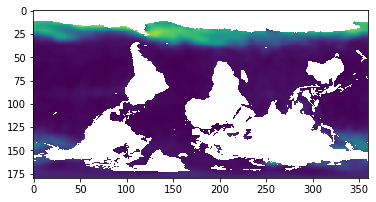

In [11]:
plt.imshow(sio3.i_an[0,0,:,:])

In [12]:
def adjust_pop_grid(tlon,tlat,field):
    nj = tlon.shape[0]
    ni = tlon.shape[1]
    xL = int(ni/2 - 1)
    xR = int(xL + ni)

    tlon = np.where(np.greater_equal(tlon,np.min(tlon[:,0])),tlon-360.,tlon)
    lon  = np.concatenate((tlon,tlon+360.),1)
    lon = lon[:,xL:xR]

    if ni == 320:
        lon[367:-3,0] = lon[367:-3,0]+360.
    lon = lon - 360.
    lon = np.hstack((lon,lon[:,0:1]+360.))
    if ni == 320:
        lon[367:,-1] = lon[367:,-1] - 360.

    #-- trick cartopy into doing the right thing:
    #   it gets confused when the cyclic coords are identical
    lon[:,0] = lon[:,0]-1e-8

    #-- periodicity
    lat  = np.concatenate((tlat,tlat),1)
    lat = lat[:,xL:xR]
    lat = np.hstack((lat,lat[:,0:1]))

    field = np.ma.concatenate((field,field),1)
    field = field[:,xL:xR]
    field = np.ma.hstack((field,field[:,0:1]))
    return lon,lat,field

## Surface nutrient difference 

In [13]:
from matplotlib.font_manager import FontProperties

font = FontProperties()
font.set_family('serif')
font.set_name('Times New Roman')

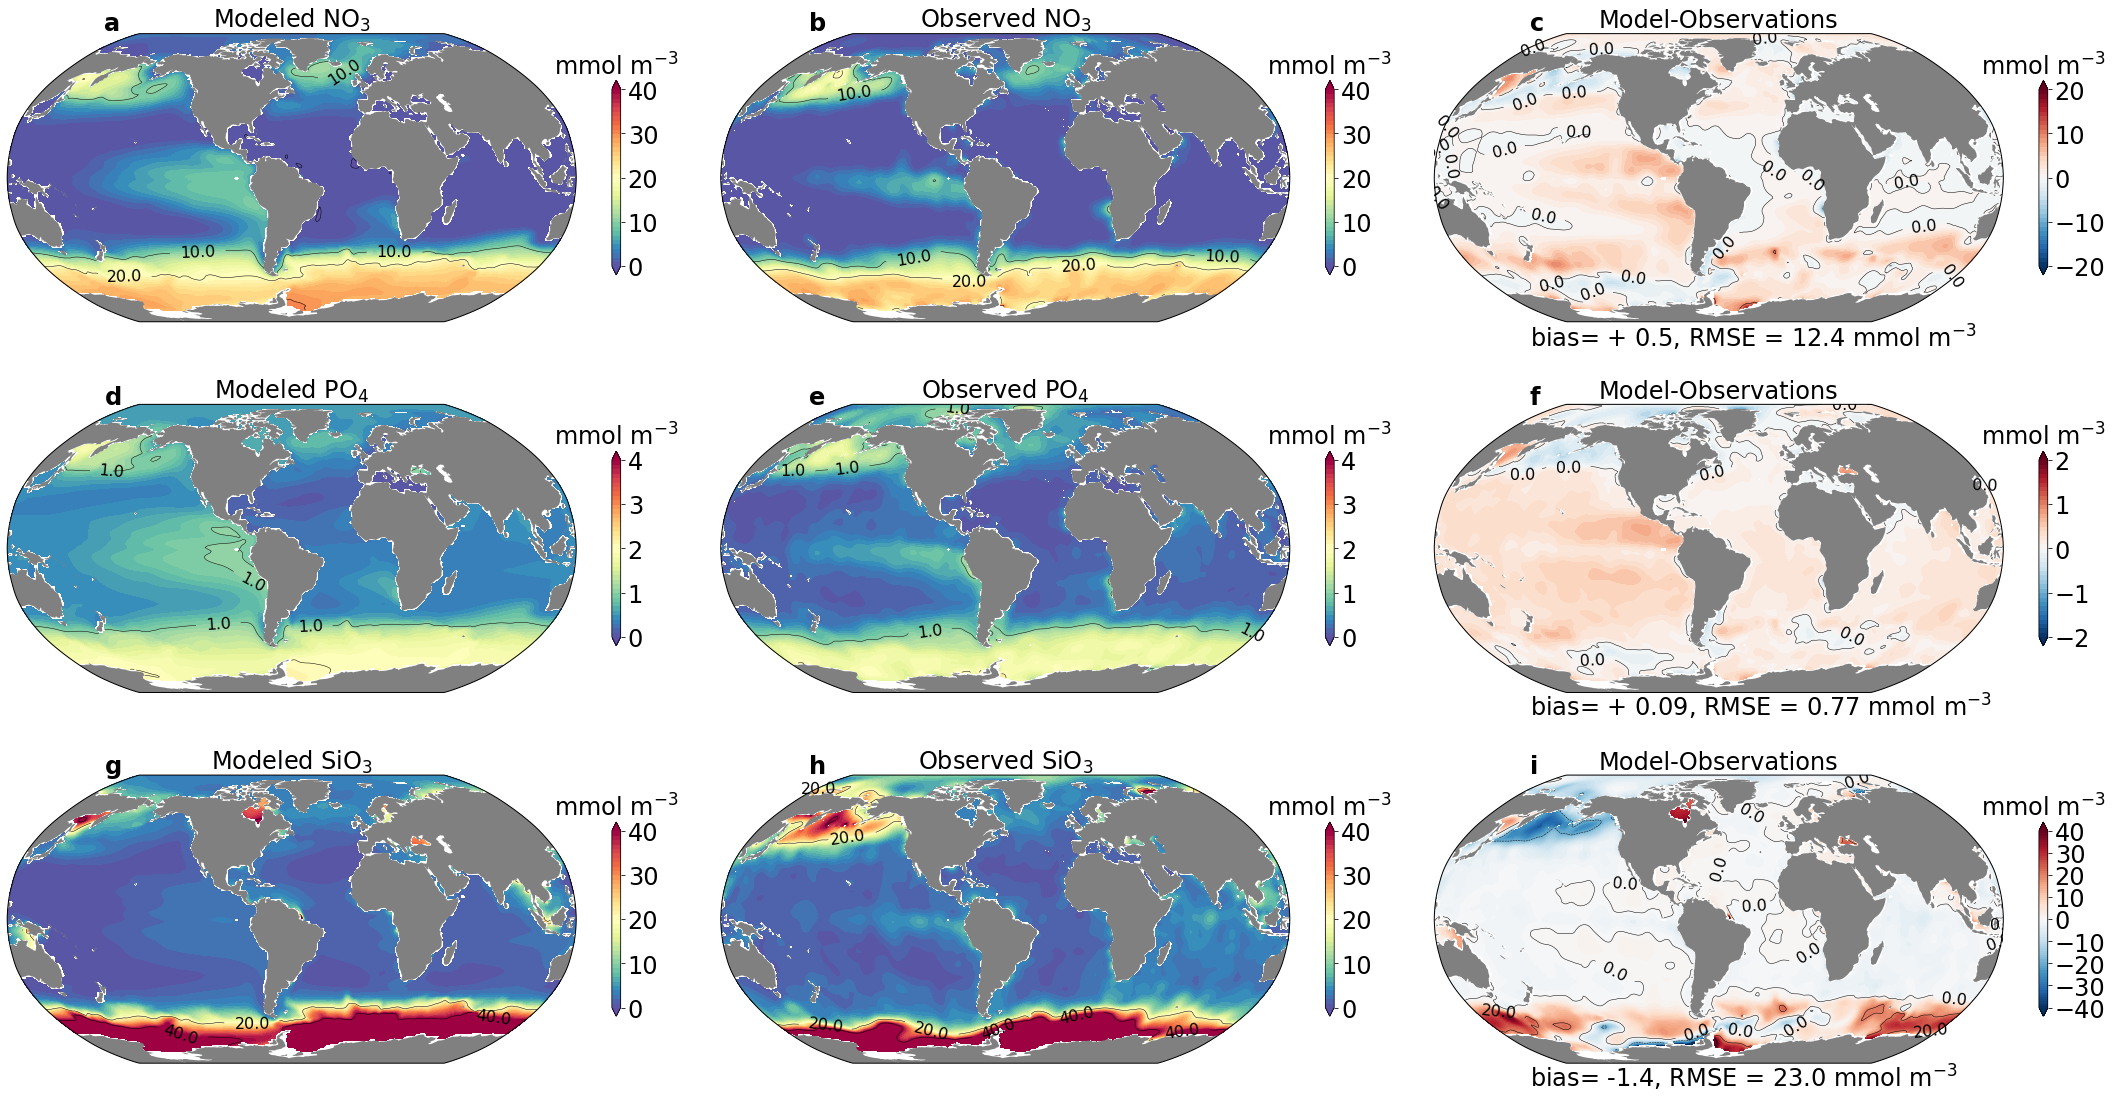

In [20]:
fig = plt.figure(figsize=(30, 16))
lat = no3.lat

## Modeled NO3
levels = np.arange(0, 41, 1)
lev = (0, 10, 20, 30, 40)
norm = colors.DivergingNorm(vmin=levels[0], vmax=levels[-1], vcenter=20.)
ax = fig.add_subplot(3, 3, 1, projection=ccrs.Robinson(central_longitude=305.0))
field1, lon = add_cyclic_point(no3_ds.NO3[:,0,:,:].mean(dim='time'), coord=no3_ds.lon, axis=1)
cf = ax.contourf(lon, lat, field1, levels=levels, extend='both',norm=norm,cmap='Spectral_r',transform=ccrs.PlateCarree());
cs = ax.contour(lon, lat, field1, colors='k', levels=lev, linewidths=0.5,transform=ccrs.PlateCarree())
lb = plt.clabel(cs, fontsize=16, inline=True, fmt='%r');
land = ax.add_feature(cartopy.feature.NaturalEarthFeature('physical','land','110m', facecolor='gray'))
cb = plt.colorbar(cf, ticks=[0, 10,20,30,40],shrink=0.5)
cb.ax.tick_params(labelsize=24)
cb.ax.set_title('mmol $m^{-3}$', fontsize = 24)
ax.set_title('Modeled $NO_3$', fontsize = 24);
fig.text(0.05, 0.95, 'a',fontsize=24, fontweight='bold')

## Observed NO3
field2, lon = add_cyclic_point(no3.n_an[0,0,:,:], coord=no3.lon, axis=1)
levels = np.arange(0, 41, 1)
lev = (0, 10, 20, 30, 40)
norm = colors.DivergingNorm(vmin=levels[0], vmax=levels[-1], vcenter=20.)
ax = fig.add_subplot(3, 3, 2, projection=ccrs.Robinson(central_longitude=305.0))
cf = ax.contourf(lon, lat, field2, levels=levels, extend='both',norm=norm,cmap='Spectral_r',transform=ccrs.PlateCarree());
cs = ax.contour(lon, lat, field2, colors='k', levels=lev, linewidths=0.5,transform=ccrs.PlateCarree())
lb = plt.clabel(cs, fontsize=16, inline=True, fmt='%r');
land = ax.add_feature(cartopy.feature.NaturalEarthFeature('physical','land','110m', facecolor='gray'))
cb = plt.colorbar(cf, ticks=[0, 10,20,30,40],shrink=0.5)
cb.ax.tick_params(labelsize=24)
cb.ax.set_title('mmol $m^{-3}$', fontsize = 24)
ax.set_title('Observed $NO_3$', fontsize = 24);
fig.text(0.376, 0.95, 'b',fontsize=24, fontweight='bold')

## Modeled - observatiosn 
levels = np.arange(-20, 20.1, 1)
lev = (-20,-10,0,10,20)
norm = colors.DivergingNorm(vmin=levels[0], vmax=levels[-1], vcenter=0.)
ax = fig.add_subplot(3, 3, 3, projection=ccrs.Robinson(central_longitude=305.0))
cf = ax.contourf(lon, lat, (field1-field2), levels=levels, norm=norm, extend='both',cmap='RdBu_r',transform=ccrs.PlateCarree());
cs = ax.contour(lon, lat, (field1-field2), colors='k', levels=lev, linewidths=0.5,transform=ccrs.PlateCarree());
lb = plt.clabel(cs, fontsize=16, inline=True, fmt='%r');
land = ax.add_feature(cartopy.feature.NaturalEarthFeature('physical','land','110m', facecolor='gray'))
cb = plt.colorbar(cf, ticks=[-20,-10,0,10,20],shrink=0.5)
cb.ax.tick_params(labelsize=24)
cb.ax.set_title('mmol $m^{-3}$', fontsize = 24)
ax.set_title('Model-Observations', fontsize = 24);
fig.text(0.71, 0.95, 'c',fontsize=24, fontweight='bold')
fig.text(0.71,0.675, 'bias= + 0.5, RMSE = 12.4 mmol $m^{-3}$', fontsize=24)

## Modeled PO4
field3, lon = add_cyclic_point(po4_ds.PO4[:,0,:,:].mean(dim='time'), coord=no3_ds.lon, axis=1)
levels = np.arange(0, 4.1, 0.1)
lev = (0, 1,2,3, 4)
norm = colors.DivergingNorm(vmin=levels[0], vmax=levels[-1], vcenter=2.)
ax = fig.add_subplot(3, 3, 4, projection=ccrs.Robinson(central_longitude=305.0))
cf = ax.contourf(lon, lat, field3, levels=levels, extend='both',norm=norm,cmap='Spectral_r',transform=ccrs.PlateCarree());
cs = ax.contour(lon, lat, field3, colors='k', levels=lev, linewidths=0.5,transform=ccrs.PlateCarree())
lb = plt.clabel(cs, fontsize=16, inline=True, fmt='%r');
land = ax.add_feature(cartopy.feature.NaturalEarthFeature('physical','land','110m', facecolor='gray'))
cb = plt.colorbar(cf, ticks=[0, 1,2,3, 4],shrink=0.5)
cb.ax.tick_params(labelsize=24)
cb.ax.set_title('mmol $m^{-3}$', fontsize = 24)
ax.set_title('Modeled $PO_4$', fontsize = 24);
fig.text(0.05, 0.625, 'd',fontsize=24, fontweight='bold')

## Observed PO4
field4, lon = add_cyclic_point(po4.p_an[0,0,:,:], coord=po4.lon, axis=1)
levels = np.arange(0, 4.1, 0.1)
lev = (0, 1,2,3, 4)
norm = colors.DivergingNorm(vmin=levels[0], vmax=levels[-1], vcenter=2.)
ax = fig.add_subplot(3, 3, 5, projection=ccrs.Robinson(central_longitude=305.0))
cf = ax.contourf(lon, lat, field4, levels=levels, extend='both',norm=norm,cmap='Spectral_r',transform=ccrs.PlateCarree());
cs = ax.contour(lon, lat, field4, colors='k', levels=lev, linewidths=0.5,transform=ccrs.PlateCarree())
lb = plt.clabel(cs, fontsize=16, inline=True, fmt='%r');
land = ax.add_feature(cartopy.feature.NaturalEarthFeature('physical','land','110m', facecolor='gray'))
cb = plt.colorbar(cf, ticks=[0, 1,2,3, 4],shrink=0.5)
cb.ax.tick_params(labelsize=24)
cb.ax.set_title('mmol $m^{-3}$', fontsize = 24)
ax.set_title('Observed $PO_4$', fontsize = 24);
fig.text(0.376, 0.625, 'e',fontsize=24, fontweight='bold')

## Modeled - Observed 
levels = np.arange(-2, 2.1, 0.1)
lev = (-2, -1, 0,1, 2)
norm = colors.DivergingNorm(vmin=levels[0], vmax=levels[-1], vcenter=0.)
ax = fig.add_subplot(3, 3, 6, projection=ccrs.Robinson(central_longitude=305.0))
cf = ax.contourf(lon, lat, (field3-field4), levels=levels, norm=norm, extend='both',cmap='RdBu_r',transform=ccrs.PlateCarree());
cs = ax.contour(lon, lat, (field3-field4), colors='k', levels=lev, linewidths=0.5,transform=ccrs.PlateCarree())
lb = plt.clabel(cs, fontsize=16, inline=True, fmt='%r');
land = ax.add_feature(cartopy.feature.NaturalEarthFeature('physical','land','110m', facecolor='gray'))
cb = plt.colorbar(cf, ticks=[-2, -1, 0,1, 2],shrink=0.5)
cb.ax.tick_params(labelsize=24)
cb.ax.set_title('mmol $m^{-3}$', fontsize = 24)
ax.set_title('Model-Observations', fontsize = 24);
fig.text(0.71, 0.625, 'f',fontsize=24, fontweight='bold')
fig.text(0.71,0.355, 'bias= + 0.09, RMSE = 0.77 mmol $m^{-3}$', fontsize=24)

## Modeled SiO3
field5, lon = add_cyclic_point(sio3_ds.SiO3[:,0,:,:].mean(dim='time'), coord=no3_ds.lon, axis=1)
levels = np.arange(0, 41, 1)
lev = (0,20,40)
norm = colors.DivergingNorm(vmin=levels[0], vmax=levels[-1], vcenter=20)
ax = fig.add_subplot(3, 3, 7, projection=ccrs.Robinson(central_longitude=305.0))
cf = ax.contourf(lon, lat, field5, levels=levels, extend='both',cmap='Spectral_r',norm=norm, transform=ccrs.PlateCarree());
cs = ax.contour(lon, lat, field5, colors='k', levels=lev, linewidths=0.5,transform=ccrs.PlateCarree())
lb = plt.clabel(cs, fontsize=16, inline=True, fmt='%r');
land = ax.add_feature(cartopy.feature.NaturalEarthFeature('physical','land','110m', facecolor='gray'))
cb = plt.colorbar(cf, ticks=[0,10,20,30,40],shrink=0.5)
cb.ax.tick_params(labelsize=24)
cb.ax.set_title('mmol $m^{-3}$', fontsize = 24)
ax.set_title('Modeled $SiO_3$', fontsize = 24);
fig.text(0.05, 0.305, 'g',fontsize=24, fontweight='bold')

## Observed SiO3
field6, lon = add_cyclic_point(sio3.i_an[0,0,:,:], coord=po4.lon, axis=1)
levels = np.arange(0, 41, 1)
lev = (0,20,40)
norm = colors.DivergingNorm(vmin=levels[0], vmax=levels[-1], vcenter=20)
ax = fig.add_subplot(3, 3, 8, projection=ccrs.Robinson(central_longitude=305.0))
cf = ax.contourf(lon, lat, field6, levels=levels,norm=norm, extend='both',cmap='Spectral_r',transform=ccrs.PlateCarree());
cs = ax.contour(lon, lat, field6, colors='k', levels=lev, linewidths=0.5,transform=ccrs.PlateCarree())
lb = plt.clabel(cs, fontsize=16, inline=True, fmt='%r');
land = ax.add_feature(cartopy.feature.NaturalEarthFeature('physical','land','110m', facecolor='gray'))
cb = plt.colorbar(cf, ticks=[0,10,20,30,40],shrink=0.5)
cb.ax.tick_params(labelsize=24)
cb.ax.set_title('mmol $m^{-3}$', fontsize = 24)
ax.set_title('Observed $SiO_3$', fontsize = 24);
fig.text(0.376, 0.305, 'h',fontsize=24, fontweight='bold')

## Modeled - Observations 
levels = np.arange(-40, 41, 1)
lev = (-40,-20,0,20,40)
norm = colors.DivergingNorm(vmin=levels[0], vmax=levels[-1], vcenter=0.)
ax = fig.add_subplot(3, 3, 9, projection=ccrs.Robinson(central_longitude=305.0))
cf = ax.contourf(lon, lat, (field5-field6), levels=levels, norm=norm, extend='both',cmap='RdBu_r',transform=ccrs.PlateCarree());
cs = ax.contour(lon, lat, (field5-field6), colors='k', levels=lev, linewidths=0.5,transform=ccrs.PlateCarree())
lb = plt.clabel(cs, fontsize=16, inline=True, fmt='%r');
land = ax.add_feature(cartopy.feature.NaturalEarthFeature('physical','land','110m', facecolor='gray'))
cb = plt.colorbar(cf, ticks=[-40,-30,-20,-10,0,10,20,30,40],shrink=0.5)
cb.ax.tick_params(labelsize=24)
cb.ax.set_title('mmol $m^{-3}$', fontsize = 24)
ax.set_title('Model-Observations', fontsize = 24);
fig.text(0.71, 0.305, 'i',fontsize=24, fontweight='bold')
fig.text(0.71, 0.033,'bias= -1.4, RMSE = 23.0 mmol $m^{-3}$',fontsize=24)
fig.tight_layout()

fig.savefig('/glade/u/home/gabyn/case_notes/analysis_figures/'+new_file+'/'+new_file+'_Nutrient_difference_WOA18'+year+'_year.jpg',dpi=600, bbox_inches='tight')

### Calculate bias and RMSE

In [15]:
#NO3
NO3_predicted = ds.NO3[:,0,:,:].mean(dim='time')
NO3_observed  = no3.n_an[:,0,:,:]
NO3_rmse = (np.nanmean((NO3_predicted-NO3_observed)**2))**0.5

# PO4
PO4_predicted = ds.PO4[:,0,:,:].mean(dim='time')
PO4_observed  = po4.p_an[0,0,:,:]
PO4_rmse = (np.nanmean((PO4_predicted-PO4_observed)**2))**0.5

# SiO3
SiO3_predicted = ds.SiO3[:,0,:,:].mean(dim='time')
SiO3_observed  = sio3.i_an[0,0,:,:]
SiO3_rmse = (np.nanmean((SiO3_predicted-SiO3_observed)**2))**0.5

In [16]:
NO3_rmse

12.398596259616827

In [17]:
PO4_rmse

0.7702698624206465

In [18]:
SiO3_rmse

22.993173664291103

In [18]:
NO3_predicted = ds.NO3[:,0,:,:].mean(dim='time')
NO3_observed  = no3.n_an[:,0,:,:]
NO3_bias = np.nanmean(NO3_predicted - NO3_observed)

PO4_predicted = ds.PO4[:,0,:,:].mean(dim='time')
PO4_observed  = po4.p_an[0,0,:,:]
PO4_bias = np.nanmean(PO4_predicted - PO4_observed)

SiO3_predicted = ds.SiO3[:,0,:,:].mean(dim='time')
SiO3_observed  = sio3.i_an[0,0,:,:]
SiO3_bias = np.nanmean(SiO3_predicted - SiO3_observed)

In [19]:
NO3_bias

0.052274637

In [20]:
PO4_bias

0.09337718

In [21]:
SiO3_bias

-1.4251732

### Check the Arctic Ocean

In [ ]:
fig = plt.figure(figsize=(30, 16))
lat = no3.lat
## Modeled NO3
m = Basemap(projection='npstere',round=True, boundinglat=65, lon_0=180+(-100+-30)/2.,resolution='c')
ax = fig.add_subplot(3, 3, 1)
field1, lon = add_cyclic_point(no3_ds.NO3[:,0,:,:].mean(dim='time'), coord=no3_ds.lon, axis=1)
x, y = m(*np.meshgrid(lon,no3_ds.lat))
cf = m.pcolor(x,y,field1,cmap='Spectral_r')
m.drawcoastlines(linewidth=0.5, linestyle='solid', color='gray', antialiased=1, ax=None, zorder=None)
m.fillcontinents(color='0.55', lake_color=None, ax=None, zorder=None, alpha=None)
cb = plt.colorbar(cf, ticks=[0, 10,20,30,40],shrink=0.5)
cb.ax.tick_params(labelsize=24)
cb.ax.set_title('mmol $m^{-3}$', fontsize = 24)
ax.set_title('Modeled $NO_3$', fontsize = 24);
fig.text(0.05, 0.95, 'a',fontsize=24, fontweight='bold')

In [ ]:
fig = plt.figure(figsize=(20, 15))
lat = no3.lat

## Modeled NO3
field1, lon = add_cyclic_point(no3_ds.NO3[:,0,:,:].mean(dim='time'), coord=no3_ds.lon, axis=1)
m = Basemap(projection='npstere',round=True, boundinglat=65, lon_0=180+(-100+-30)/2.,resolution='c')
ax = fig.add_subplot(3, 3, 1)
x, y = m(*np.meshgrid(lon,no3_ds.lat))
cf = m.pcolor(x,y,field1,cmap='Spectral_r')
m.drawcoastlines(linewidth=0.5, linestyle='solid', color='gray', antialiased=1, ax=None, zorder=None)
m.fillcontinents(color='0.55', lake_color=None, ax=None, zorder=None, alpha=None)
cb = plt.colorbar(cf, shrink=0.5)
cb.ax.tick_params(labelsize=24)
cb.ax.set_title('mmol $m^{-3}$', fontsize = 24)
ax.set_title('Modeled $NO_3$', fontsize = 24);
#fig.text(0.05, 0.95, 'a',fontsize=24, fontweight='bold')

## Observed NO3
field2, lon = add_cyclic_point(no3.n_an[0,0,:,:], coord=no3.lon, axis=1)
m = Basemap(projection='npstere',round=True, boundinglat=65, lon_0=180+(-100+-30)/2.,resolution='c')
ax = fig.add_subplot(3, 3, 2)
x, y = m(*np.meshgrid(lon,no3.lat))
cf = m.pcolor(x,y,field2,cmap='Spectral_r')
m.drawcoastlines(linewidth=0.5, linestyle='solid', color='gray', antialiased=1, ax=None, zorder=None)
m.fillcontinents(color='0.55', lake_color=None, ax=None, zorder=None, alpha=None)
cb = plt.colorbar(cf, shrink=0.5)
cb.ax.tick_params(labelsize=24)
cb.ax.set_title('mmol $m^{-3}$', fontsize = 24)
ax.set_title('Observed $NO_3$', fontsize = 24);
#fig.text(0.376, 0.95, 'b',fontsize=24, fontweight='bold')

## Modeled - observatiosn 
m = Basemap(projection='npstere',round=True, boundinglat=65, lon_0=180+(-100+-30)/2.,resolution='c')
ax = fig.add_subplot(3, 3, 3)
x, y = m(*np.meshgrid(lon,no3.lat))
cf = m.pcolor(x,y,(field1-field2),cmap='RdBu_r')
m.drawcoastlines(linewidth=0.5, linestyle='solid', color='gray', antialiased=1, ax=None, zorder=None)
m.fillcontinents(color='0.55', lake_color=None, ax=None, zorder=None, alpha=None)
cb = plt.colorbar(cf, shrink=0.5)
cb.ax.tick_params(labelsize=24)
cb.ax.set_title('mmol $m^{-3}$', fontsize = 24)
ax.set_title('(Model-Obs.)$NO_3$', fontsize = 24);
#fig.text(0.71, 0.95, 'c',fontsize=24, fontweight='bold')

## Modeled PO4
field3, lon = add_cyclic_point(po4_ds.PO4[:,0,:,:].mean(dim='time'), coord=no3_ds.lon, axis=1)
m = Basemap(projection='npstere',round=True, boundinglat=65, lon_0=180+(-100+-30)/2.,resolution='c')
ax = fig.add_subplot(3, 3, 4)
x, y = m(*np.meshgrid(lon,no3.lat))
cf = m.pcolor(x,y,field3,cmap='Spectral_r')
m.drawcoastlines(linewidth=0.5, linestyle='solid', color='gray', antialiased=1, ax=None, zorder=None)
m.fillcontinents(color='0.55', lake_color=None, ax=None, zorder=None, alpha=None)
cb = plt.colorbar(cf, shrink=0.5)
cb.ax.tick_params(labelsize=24)
cb.ax.set_title('mmol $m^{-3}$', fontsize = 24)
ax.set_title('Modeled $PO_4$', fontsize = 24);
#fig.text(0.05, 0.625, 'd',fontsize=24, fontweight='bold')

## Observed PO4
field4, lon = add_cyclic_point(po4.p_an[0,0,:,:], coord=po4.lon, axis=1)
m = Basemap(projection='npstere',round=True, boundinglat=65, lon_0=180+(-100+-30)/2.,resolution='c')
ax = fig.add_subplot(3, 3, 5)
x, y = m(*np.meshgrid(lon,no3.lat))
cf = m.pcolor(x,y,field4,cmap='Spectral_r')
m.drawcoastlines(linewidth=0.5, linestyle='solid', color='gray', antialiased=1, ax=None, zorder=None)
m.fillcontinents(color='0.55', lake_color=None, ax=None, zorder=None, alpha=None)
cb = plt.colorbar(cf, shrink=0.5)
cb.ax.tick_params(labelsize=24)
cb.ax.set_title('mmol $m^{-3}$', fontsize = 24)
ax.set_title('Observed $PO_4$', fontsize = 24);
#fig.text(0.376, 0.625, 'e',fontsize=24, fontweight='bold')

## Modeled - Observed 
m = Basemap(projection='npstere',round=True, boundinglat=65, lon_0=180+(-100+-30)/2.,resolution='c')
ax = fig.add_subplot(3, 3, 6)
x, y = m(*np.meshgrid(lon,no3.lat))
cf = m.pcolor(x,y,(field3-field4),cmap='RdBu_r')
m.drawcoastlines(linewidth=0.5, linestyle='solid', color='gray', antialiased=1, ax=None, zorder=None)
m.fillcontinents(color='0.55', lake_color=None, ax=None, zorder=None, alpha=None)
cb = plt.colorbar(cf, shrink=0.5)
cb.ax.tick_params(labelsize=24)
cb.ax.set_title('mmol $m^{-3}$', fontsize = 24)
ax.set_title('(Model-Obs.)$PO_4$', fontsize = 24);
#fig.text(0.71, 0.625, 'f',fontsize=24, fontweight='bold')

## Modeled SiO3
field5, lon = add_cyclic_point(sio3_ds.SiO3[:,0,:,:].mean(dim='time'), coord=no3_ds.lon, axis=1)
m = Basemap(projection='npstere',round=True, boundinglat=65, lon_0=180+(-100+-30)/2.,resolution='c')
ax = fig.add_subplot(3, 3, 7)
x, y = m(*np.meshgrid(lon,no3.lat))
cf = m.pcolor(x,y,field5,cmap='Spectral_r')
m.drawcoastlines(linewidth=0.5, linestyle='solid', color='gray', antialiased=1, ax=None, zorder=None)
m.fillcontinents(color='0.55', lake_color=None, ax=None, zorder=None, alpha=None)
cb = plt.colorbar(cf, shrink=0.5)
cb.ax.tick_params(labelsize=24)
cb.ax.set_title('mmol $m^{-3}$', fontsize = 24)
ax.set_title('Modeled $SiO_3$', fontsize = 24);
#fig.text(0.05, 0.305, 'g',fontsize=24, fontweight='bold')

## Observed SiO3
field6, lon = add_cyclic_point(sio3.i_an[0,0,:,:], coord=po4.lon, axis=1)
m = Basemap(projection='npstere',round=True, boundinglat=65, lon_0=180+(-100+-30)/2.,resolution='c')
ax = fig.add_subplot(3, 3, 8)
x, y = m(*np.meshgrid(lon,no3.lat))
cf = m.pcolor(x,y,field6,cmap='Spectral_r')
m.drawcoastlines(linewidth=0.5, linestyle='solid', color='gray', antialiased=1, ax=None, zorder=None)
m.fillcontinents(color='0.55', lake_color=None, ax=None, zorder=None, alpha=None)
cb = plt.colorbar(cf,shrink=0.5)
cb.ax.tick_params(labelsize=24)
cb.ax.set_title('mmol $m^{-3}$', fontsize = 24)
ax.set_title('Observed $SiO_3$', fontsize = 24);
#fig.text(0.376, 0.305, 'h',fontsize=24, fontweight='bold')

## Modeled - Observations 
m = Basemap(projection='npstere',round=True, boundinglat=65, lon_0=180+(-100+-30)/2.,resolution='c')
ax = fig.add_subplot(3, 3, 9)
x, y = m(*np.meshgrid(lon,no3.lat))
cf = m.pcolor(x,y,(field5-field6),cmap='RdBu_r')
m.drawcoastlines(linewidth=0.5, linestyle='solid', color='gray', antialiased=1, ax=None, zorder=None)
m.fillcontinents(color='0.55', lake_color=None, ax=None, zorder=None, alpha=None)
cb = plt.colorbar(cf,shrink=0.5)
cb.ax.tick_params(labelsize=24)
cb.ax.set_title('mmol $m^{-3}$', fontsize = 24)
ax.set_title('(Model-Obs.)$SiO_3$', fontsize = 24);
#fig.text(0.71, 0.305, 'i',fontsize=24, fontweight='bold')

fig.tight_layout()

fig.savefig('/glade/u/home/gabyn/case_notes/analysis_figures/'+new_file+'/'+new_file+'_Arctic_Nutrients_WOA18'+year+'_year.jpg',dpi=600, bbox_inches='tight')